In [1]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io #Used to load the OCTAVE *.mat files
import scipy.misc #Used to show matrix as an image
import matplotlib.cm as cm #Used to display images in a specific colormap
import random #To pick random images to display
import scipy.optimize #fmin_cg to train neural network
import itertools
from scipy.special import expit #Vectorized sigmoid function

In [2]:
datafile = 'data/ex4data1.mat'
weightsfile = 'data/ex4weights.mat'
mat = scipy.io.loadmat(datafile)
weights = scipy.io.loadmat(weightsfile)
Theta1, Theta2 = weights['Theta1'], weights['Theta2']
X, y = mat['X'], mat['y']
print('Number of examples {}'.format(X.shape[0]))
print('pixels per example {}'.format(X[0].shape[0]))
print('Different classes for Y: {}'.format(np.unique(y)))
print('Theta1 shape: {}'.format(Theta1.shape))
print('Theta2 shape: {}'.format(Theta2.shape))


Number of examples 5000
pixels per example 400
Different classes for Y: [ 1  2  3  4  5  6  7  8  9 10]
Theta1 shape: (25, 401)
Theta2 shape: (10, 26)


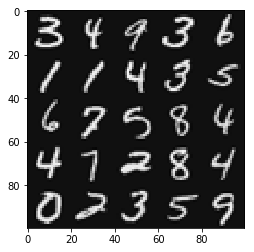

    [3]   [4]   [9]   [3]   [6]   
    [1]   [1]   [4]   [3]   [5]   
    [6]   [7]   [5]   [8]   [4]   
    [4]   [7]   [2]   [8]   [4]   
    [0]   [2]   [3]   [5]   [9]   


In [3]:
def display_numbers(indices=None, NN_guess=None):
    if indices is None:
        indices = [random.randrange(len(X)) for n in range(25)]
    elif len(indices) > 25:
        display_numbers(indices[0:25], NN_guess)
        display_numbers(indices[25:], NN_guess)
        return
    grid = None
    sqrt_num = math.ceil(math.sqrt(len(indices)))
    for n in range(sqrt_num):
        row = None
        for m in range(sqrt_num):
            if sqrt_num*n+m >= len(indices):
                if row is None:
                    row = np.zeros((20, 20))
                else:
                    row = np.concatenate((row, np.zeros((20, 20))), axis=1)
            elif row is None:
                row = np.array(X[indices[sqrt_num*n+m]]).reshape(20, 20, order='F')
            else:
                number = np.array(X[indices[sqrt_num*n+m]]).reshape(20, 20, order='F')
                row = np.concatenate((row, number), axis=1)
        if grid is None:
            grid = row
        else:
            grid = np.concatenate((grid, row), axis=0)
    plt.imshow(grid, interpolation='nearest', cmap='gray')
    plt.show()
    
    # print correct answers
    for n in range(sqrt_num):
        print('    ', end='')
        for m in range(sqrt_num):
            if sqrt_num*n+m >= len(indices):
                break
            if NN_guess is None:
                print('{}   '.format(y[indices[sqrt_num*n+m]]%10), end='')
            else:
                print('{0}:{1}   '.format(y[indices[sqrt_num*n+m]][0]%10, NN_guess[sqrt_num*n+m]%10), end='')
        print()
    
display_numbers()

In [4]:
def sigmoid(value):
    return expit(value)

def forward_prop(input_data, Theta1, Theta2):
    input_data = np.insert(input_data, 0, 1, axis=1)
    
    z1 = np.dot(input_data, Theta1.transpose())
    a1 = sigmoid(z1)
    a1 = np.insert(a1, 0, 1, axis=1)

    z2 = np.dot(a1, Theta2.transpose())
    a2 = sigmoid(z2)
    return a2

In [5]:
print(np.insert(X, 0, 1, axis=1).shape)
print(Theta1.shape)
print(Theta2.shape)

(5000, 401)
(25, 401)
(10, 26)


In [6]:
count = 0
guess = forward_prop(X, Theta1, Theta2)
guess = (np.argmax(guess, axis=1)+1)%10
actual = (y%10).reshape(-1)
delta = guess - actual

wrong_count = np.count_nonzero(delta)

print('{} out of {} correct'.format(len(X) - wrong_count, len(X)))
print('Accuracy: {}%'.format((len(X) - wrong_count)/len(X)*100))

indices = [n for n in range(len(delta)) if delta[n] != 0]
NN_guess = [n for n in delta if n != 0]
# display_numbers(indices, NN_guess)

4876 out of 5000 correct
Accuracy: 97.52%


In [93]:
def flattenArrays(arrays):
    sizeInfo = [arr.shape for arr in arrays]
    flattenedArrays = np.concatenate(tuple(arr.reshape(1, -1) for arr in arrays), axis=1)
    return (flattenedArrays, sizeInfo)
    
def recoverFlattenedArrays(flattenedArrays, sizeInfo):
    indices = list(itertools.accumulate([0] + [n[0]*n[1] for n in sizeInfo]))
    recovered_arrays = []
    for key, shape in enumerate(sizeInfo):
        current_array = (flattenedArrays[0][indices[key]:indices[key+1]]).reshape(*shape)
        recovered_arrays.append(current_array)
    return recovered_arrays

def recoverThetas(thetas_flattened):
    size_info = [Theta1.shape, Theta2.shape]
    return recoverFlattenedArrays(thetas_flattened, size_info)

def recoverX(X_flattened):
    size_info = [X.shape]
    return recoverFlattenedArrays(X_flattened, size_info)
        

def costFunction(myThetas_flattened, myX_flattened, myy, myLambda=0):
    thetas = recoverThetas(myThetas_flattened)
    theta1 = thetas[0]
    theta2 = thetas[1]
    myX = recoverX(myX_flattened)[0]
    num_examples = myX.shape[0]
    
    hypothosis = forward_prop(myX, theta1, theta2)
    
    expanded_y = np.insert(np.zeros(9), myy[0]-1, 1)
    for n in y[1:]:
        expanded_y = np.concatenate((expanded_y, np.insert(np.zeros(9), n-1, 1)))
    expanded_y = expanded_y.reshape(-1, 10)
    cost = -1/num_examples * np.sum(expanded_y*np.log(hypothosis)+(1-expanded_y)*np.log(1-hypothosis))
    
    reg = 0
    reg = np.sum(np.power(theta1[:, 1:], 2))
    reg += np.sum(np.power(theta2[:, 1:], 2))
    reg *= myLambda/(2*num_examples)
    return cost + reg

def sigmoidGradient(value):
    temp = sigmoid(value)
    return temp*(1-temp)

def genRandThetas():
    epsilon_init = 0.12
    return [np.random.rand(25, 400) * 2 * epsilon_init - epsilon_init, 
            np.random.rand(10, 25) * 2 * epsilon_init - epsilon_init]

array([ 0.25      ,  0.25      ,  0.19661193])

30

In [235]:
l1 = 'ABC'
l2 = 'AC'
grid = [[0 for col in range(len(l1)+1)] for row in range(len(l2)+1)]
for key_row, row in enumerate(grid):
    if key_row == 0:
        continue
    for key_col, col in enumerate(row):
        if key_col == 0:
            continue
        if l1[key_col-1] == l2[key_row-1]:
            grid[key_row][key_col] = grid[key_row-1][key_col-1]+1
        else:
            grid[key_row][key_col] = max(grid[key_row-1][key_col], grid[key_row][key_col-1])
print(grid[-1][-1])

2
